# Final Project - DA 353

## Dr. Bonifonte
## Minh Le & Yen Nguyen


### I. Background and Introduction

The adoption of electric vehicles (EVs) is increasing worldwide, mainly driven by growing awareness of environmental issues and technological advancements. These types of vehicles are now favored and recognized by the majority of consumers. With the increasing number of new energy electric vehicles, the demand for charging stations for these vehicles is also increasing. This makes the strategic placement of charging stations crucial, helping the government optimize infrastructure efficiency by minimizing the need for excessive stations. Finding the right locations for these stations is therefore important, ensuring they can provide convenient access for all EV users, while contributing to a more sustainable future of transportation.

For this project, we aim to optimize the allocation of electric vehicles charging stations locations that effectively minimize the number of stations. We chose Washington state for our optimization model. Since the current data is too large, we plan to focus on the metropolitan area in Washington state, such as Seattle, to reduce the complexity of the problem. Based on the given dataset provided by data.gov about the registered electric vehicles, we are hoping to effectively design and build strategic placements of stations that can cover all the locations and meet the demand of those registered cars.


### II. Data Preprocessing & Exploration
Now, we will select all the data we need for our optimization problem. We will only focus on the biggest city in Washington State, which is Seattle. 

In [1]:
# import packages
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import geopy.distance
import folium
from itertools import combinations, permutations, product
from math import sqrt

In [2]:
# load datset and select needed columns
df = pd.read_csv("./Electric_Vehicle_Population_Data.csv")
df = df[["VIN (1-10)", "County", "City", "Postal Code", "Electric Range", "Vehicle Location"]]
df.set_index("VIN (1-10)", inplace=True)

In [3]:
# select data that are from Seattle
df_seattle = df.loc[df["City"] == "Seattle"]
df_seattle.head()

,County,City,Postal Code,Electric Range,Vehicle Location
VIN (1-10),,,,,
5YJYGDEE1L,King,Seattle,98122.0,291,POINT (-122.30839 47.610365)
5YJSA1E4XK,King,Seattle,98109.0,270,POINT (-122.34848 47.632405)
5YJYGDEEXL,King,Seattle,98144.0,291,POINT (-122.30823 47.581975)
1N4AZ0CP0F,King,Seattle,98119.0,84,POINT (-122.363815 47.63046)
1N4AZ0CP6D,King,Seattle,98107.0,75,POINT (-122.37815 47.66866)


First, we want to explore the locations of all the registered vehicles. We will use `Postal Code` to identify where the EVs are registered in Seattle.

In [4]:
# select unique postal code in the dataset
unique_postal_codes = df_seattle['Postal Code'].unique()

# how many vehicles are there for each postal code?
postal_code_counts = df_seattle.groupby('Postal Code').size().reset_index(name='Count')

# Create a grid representation using postal codes
grid = {}

# Populate grid with coordinates
for index, row in df_seattle.iterrows():
    code = row['Postal Code']
    log = row["Vehicle Location"].split(" ")[1][1:]
    lat = row["Vehicle Location"].split(" ")[2][:-1]
    grid[code] = (float(lat), float(log))

We will now create a map to see the location of each `Postal Code`:

In [5]:
#Plot the map for model 1
map_mod_1 = folium.Map(location=[47.6062, -122.3321], zoom_start=10.45)
for key, value in grid.items():
    folium.Marker(location=value,
                    popup=key,
                    icon=folium.Icon(color='blue')).add_to(map_mod_1)
        
map_mod_1

For further development and analysis, we will convert the location of our `Postal Code` to a grid location.

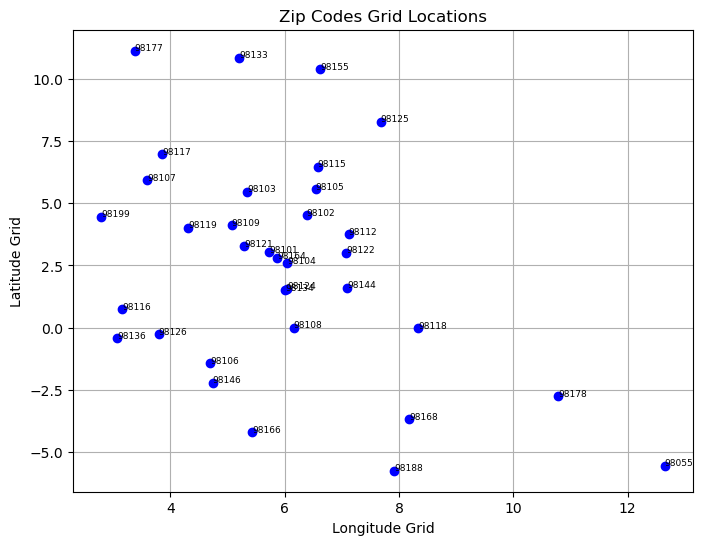

In [6]:
# Define maximum and minimum longitude and latitude ranges
min_lon, max_lon = -122.45, -122.25  
min_lat, max_lat = 47.55, 47.75  

# Define grid size
grid_size = 10

# Function to map longitude and latitude to grid location
def map_to_grid(lon, lat):
    lon_idx = (lon - min_lon) / (max_lon - min_lon) * grid_size
    lat_idx = (lat - min_lat) / (max_lat - min_lat) * grid_size
    return lon_idx, lat_idx

# Convert coordinates to grid locations
grid_locations = {zipcode: map_to_grid(lon, lat) for zipcode, (lat, lon) in grid.items()}

# Plot grid locations
plt.figure(figsize=(8, 6))
for zipcode, (lon_idx, lat_idx) in grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'bo')
    plt.text(lon_idx, lat_idx, str(int(zipcode)), fontsize=6.5)

plt.title('Zip Codes Grid Locations')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.grid(True)
plt.show()

In [7]:
# Grid locations converted from the given longitudes and latitudes of postal codes
df = pd.DataFrame.from_dict(grid_locations, orient='index', columns=["Longitude", "Latitude"])

# Compute the maximum and minimum longitude and latitude converted grid locations
max_longitude = df["Longitude"].max()
min_longitude = df["Longitude"].min()
max_latitude = df["Latitude"].max()
min_latitude = df["Latitude"].min()

print("Maximum Longitude:", max_longitude)
print("Minimum Longitude:", min_longitude)
print("Maximum Latitude:", max_latitude)
print("Minimum Latitude:", min_latitude)

Maximum Longitude: 12.649999999999826
Minimum Longitude: 2.7907500000004464
Maximum Latitude: 11.13950000000001
Minimum Latitude: -5.763499999999684


Given the grid locations converted from zip code coordinates, we want to identify suitable candidate locations for charging stations. By determining the maximum and minimum coordinates of these converted grid locations, we establish the range within which candidate locations should be selected: longitude [3, 13] and latitude [-6, 12]. We prioritize **integer points** on the grid as potential candidate locations. This approach ensures that the selected locations align with the grid system's structure, facilitating the efficient placement of charging stations.

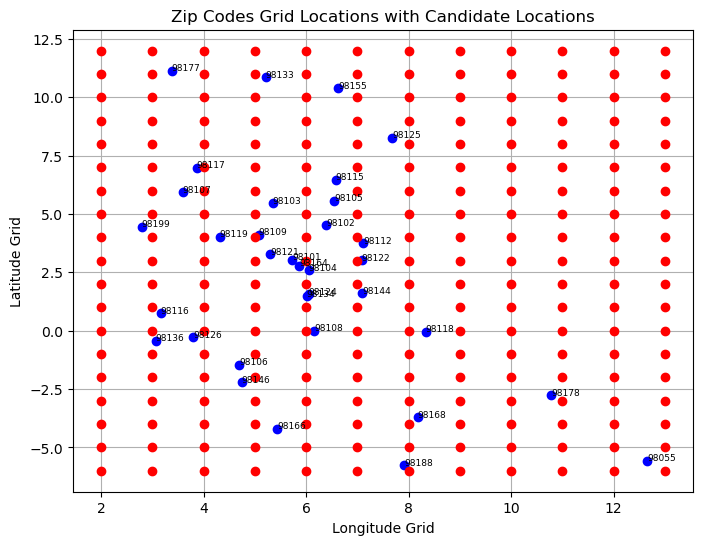

In [8]:
# Select candidate grid locations within the specified range
candidate_grid_locations = {idx: (i, j) for idx, (i, j) in enumerate([(i, j) for i in range(2, 14) for j in range(-6, 13)])}

# Plot grid locations
plt.figure(figsize=(8, 6))
for zipcode, (lon_idx, lat_idx) in grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'bo')
    plt.text(lon_idx, lat_idx, str(int(zipcode)), fontsize=6.5)

# Plot candidate locations (red points)
for candidate, (lon_idx, lat_idx) in candidate_grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'ro')

plt.title('Zip Codes Grid Locations with Candidate Locations')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.grid(True)
plt.show()

From the grid, it's clear that there's an empty space in the top-right corner, defined by longitude [10, 13] and latitude [-1, 12], where no blue points (representing postal codes) are present. Consequently, we can confidently exclude this area from our candidate location list for optimization purposes. By removing these points, we streamline our optimization model, focusing it on areas with existing postal codes and potentially enhancing its efficiency.

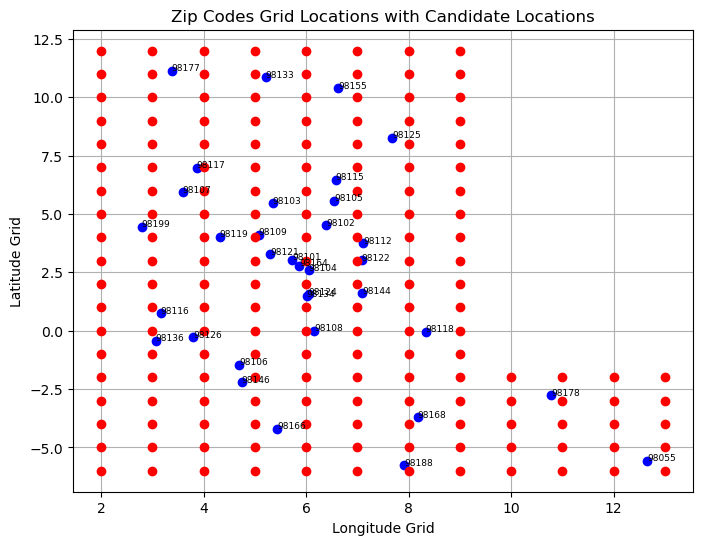

In [9]:
# Define the grid locations you want to remove
locations_to_remove = {(i, j) for i in range(10, 14) for j in range(-1, 13)}

# Remove the specified grid locations from candidate_grid_locations
candidate_grid_locations = {idx: (i, j) for idx, (i, j) in candidate_grid_locations.items() if (i, j) not in locations_to_remove}

# Plot grid locations
plt.figure(figsize=(8, 6))
for zipcode, (lon_idx, lat_idx) in grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'bo')
    plt.text(lon_idx, lat_idx, str(int(zipcode)), fontsize=6.5)

# Plot candidate locations (red points)
for candidate, (lon_idx, lat_idx) in candidate_grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'ro')

plt.title('Zip Codes Grid Locations with Candidate Locations')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.grid(True)
plt.show()


### III. Model Formulation

To streamline our project, we make the following assumptions:
- We assume uniform power consumption demand for each vehicle, approximating it based on the average power consumption of electric cars. 
- We consider the construction cost as well as the power capacity of a new station to be consistent across all locations and irrespective of demand variations.
- We assume the location of each vehicles is specified by `Postal Code`.
- We have a fixed budget so we are only able to open 150 stations. 
- Maximum supply of each charging station: 50 cars

We want to develop a linear programming model to solve the problem. The structure of the model is:

1. <b> Set: </b>
    - Let $Z$ represent the set of postal codes obtained from the dataset.
    - Let $S$ denote the set of candidate charging locations
2. <b> Data: </b>
    - $D$: the maximum certain distance threshold between the charging location and the vehicle
    - $S_j$: the maximum supply of the charging station $j$
    - $d_{ij}$: the distance between vehicle in postal code $i$ ($i \in Z$) and station $j$ ($j \in S$)
    - $n_i$: the number of cars require charging in postal code $i$

3. <b> Decision Variables: </b>
    - $C_{j}$: Binary variable indicating whether to open the charging station $j$, $j \in S$.
    - $X_{ij}$: Continuous variable representing the proportion of vehicles in postal code $i$ ($i \in Z$) chooses station $j$ ($j \in S$) for charging service.

4. <b> Objective Function: </b> Maximize the power coverage of the stations opened
\begin{equation*} 
\max \displaystyle\sum_{i \in Z} n_i X_{ij}
\end{equation*}

5. <b> Constraints: </b>
    - Only charge at the stations that have been selected: $ X_{ij} <= C_{j} \quad \forall i\in Z, j\in S$
    - Vehicle charging constraint: $\displaystyle \sum_{j\in S} X_{ij} \leq 1 \quad \forall i\in Z$
    - Limit the distance between each postal code and its assigned charging station to a maximum threshold of D units: 
    $d_{ij} C_j \leq D \quad \forall i \in Z, j \in S$
    - Ensure that the total demand (based on the number of cars requiring charging) supplied by each charging station does not exceed its maximum supply:
    $\displaystyle \sum_{i \in Z} n_i X_{ij} \leq S_j \quad \forall j\in S$
    -  Ensure that only 100 stations are opened: $\displaystyle \sum_{j \in S} C_j <= 100$

### IV. Model Implementation

In [10]:
# Function to create the Euclidean distances between the charging locations and the vehicles in zip code i
def distance(loc1, loc2):
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return sqrt(dx*dx + dy*dy)

# List of postal codes and list of candidate indices
codes = grid_locations.keys()
candidate = candidate_grid_locations.keys()

# Generate a list of pairs of postal codes and the candidate indices
cartesian_prod = list(product(codes, candidate))

# Compute the distances between each pair of code and candidate stations
distances = {(c, f): distance(grid_locations[c], candidate_grid_locations[f]) for c, f in cartesian_prod}

We now set the maximum distance threshold between the charging location and the vehicle to be within 2.0 unit in grid locations. 

In [11]:
def maximum_dist_thres(threshold):
    dict = {}
    for c, f in cartesian_prod:
        if distances[(c, f)] <= threshold:
            dict[(c, f)] = distances[(c, f)]
    return dict

threshold = 2.0 # set the threshold to be 2.0
distances_filtered = maximum_dist_thres(threshold)

In [12]:
# Model 1 
model1 = gp.Model("Station Cover")
model1.Params.LogToConsole = 0 # Suppress noisy output

## Data
### Number of cars requires charging at location i
n = postal_code_counts.set_index('Postal Code')['Count'].to_dict()

## Variables: 
### Whether to open charging station j?
C = model1.addVars(candidate_grid_locations.keys(), vtype = GRB.BINARY, name = "c")

### The proportion of vehicles in postal code i choose station j for charging service
X_var = model1.addVars(cartesian_prod, lb = 0.0, ub = 1.0, vtype = GRB.CONTINUOUS, name = "x")

## Objective
model1.setObjective(gp.quicksum(X_var[i, j] * n[i] for i, j in cartesian_prod), GRB.MAXIMIZE)

## Constraints
### Vehicle charging constraint
model1.addConstrs(gp.quicksum(X_var[i, j] for j in candidate_grid_locations.keys()) <= 1 for i in grid_locations.keys())

### Distances Constraints
model1.addConstrs(gp.quicksum(distances[i, j] * X_var[i, j] for i in grid_locations.keys()) <= 2.0 for j in candidate_grid_locations.keys()) #problem

### Supply-Demand balance constraint
model1.addConstrs(gp.quicksum(n[i] * X_var[i, j] for i in grid_locations.keys()) <= 5500 for j in candidate_grid_locations.keys())

### Restrict the number of station to be constructed#
model1.addConstr(gp.quicksum(C[j] for j in candidate_grid_locations.keys()) <= 100)

### Can be charge only when there is charging location
model1.addConstrs(X_var[i, j] <= C[j] for i, j in cartesian_prod)

model1.optimize()

if model1.status == GRB.OPTIMAL:
    print("Optimal Solution:")
    print(model1.ObjVal)
    result = []
    res = []
    for j in candidate_grid_locations.keys():
        if C[j].x > 0.5:
            res.append(C[j].x)
            result.append(j)
        #print(C[j].x)
else:
    print("No optimal solution found.")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-06
Optimal Solution:
29447.000000000004


In [13]:
for i, j in cartesian_prod:
    if j in result:
        if X_var[i, j].x > 0:
            print(i, j, X_var[i, j].x * n[i])

98122.0 67 839.9483222212231
98122.0 101 449.0516777787769
98109.0 67 1447.0
98144.0 64 495.77930901407007
98144.0 119 436.93238622342795
98144.0 121 294.288304762502
98119.0 48 930.0
98107.0 13 988.2602396986805
98107.0 85 70.73976030131954
98126.0 6 524.6494573667226
98126.0 62 291.35054263327737
98118.0 119 1492.0
98108.0 62 652.8352078122294
98108.0 116 13.164792187770564
98121.0 6 21.309807578450666
98121.0 10 150.99644160418302
98121.0 124 321.3767354705156
98121.0 139 335.3170153468507
98115.0 90 1566.8424916963158
98115.0 127 1150.1575083036842
98101.0 85 623.0
98178.0 96 30.167101068402378
98178.0 175 25.40308939117421
98178.0 212 481.4298095404234
98117.0 10 685.0236424694399
98117.0 32 819.6211237078431
98117.0 106 234.355233822717
98125.0 127 1291.0404586868044
98125.0 131 111.95954131319573
98133.0 53 554.8630370611995
98133.0 131 61.136962938800494
98102.0 106 804.0
98112.0 124 1491.0
98177.0 55 540.0
98103.0 13 123.81142361665212
98103.0 46 1164.506628120788
98103.0 90 8

In [14]:
ck = []
cand = {}
gr = {}
for i, j in distances_filtered.keys():
    ck.append((i, j))
    cand[j] = candidate_grid_locations[j]
    gr[i] = grid_locations[i]

In [15]:
# Model 2
model1 = gp.Model("Station Cover")
model1.Params.LogToConsole = 0 # Suppress noisy output

## Data
### Number of cars requires charging at location i
n = postal_code_counts.set_index('Postal Code')['Count'].to_dict()

## Variables: 
### Whether to open charging station j?
C = model1.addVars(cand.keys(), vtype = GRB.BINARY, name = "c")

### The proportion of vehicles in postal code i choose station j for charging service
X_var = model1.addVars(ck, lb = 0.0, ub = 1.0, vtype = GRB.CONTINUOUS, name = "x")

## Objective
model1.setObjective(gp.quicksum(X_var[i, j] * n[i] for i, j in ck), GRB.MAXIMIZE)

## Constraints
### Vehicle charging constraint
model1.addConstrs(gp.quicksum(X_var[i, j] for j in cand.keys() if (i, j) in ck) <= 1 for i in grid_locations.keys())

### Distances Constraints
#model1.addConstrs(gp.quicksum(distances[i, j] * X_var[i, j] for i in grid_locations.keys()) <= 2.0 for j in cand.keys()) #problem

### Supply-Demand balance constraint
model1.addConstrs(gp.quicksum(n[i] * X_var[i, j] for i in grid_locations.keys() if (i, j) in ck) <= 1000 for j in cand.keys())

### Restrict the number of station to be constructed#
model1.addConstr(gp.quicksum(C[j] for j in cand.keys()) <= 100)

### Can be charge only when there is charging location
model1.addConstrs(X_var[i, j] <= C[j] for i, j in ck)

model1.optimize()

if model1.status == GRB.OPTIMAL:
    print("Optimal Solution:")
    print(model1.ObjVal)
    result = []
    res = []
    for j in cand.keys():
        if C[j].x > 0.5:
            res.append(C[j].x)
            result.append(j)
        #print(C[j].x)
else:
    print("No optimal solution found.")

Optimal Solution:
29447.0


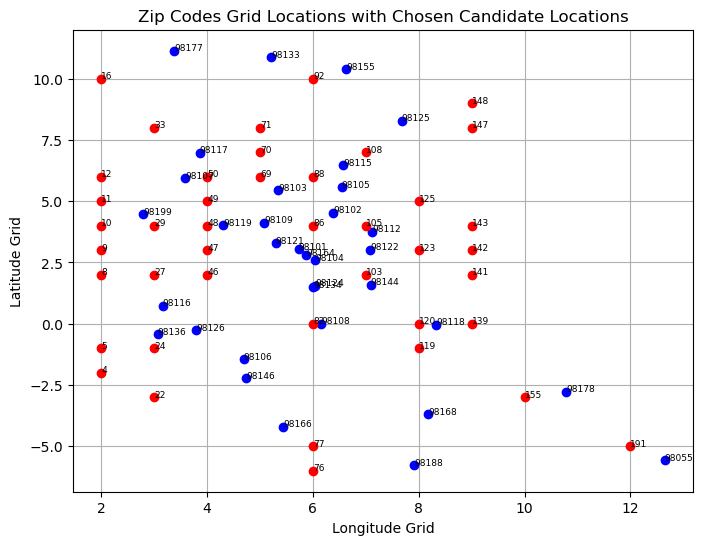

In [16]:
# Select the chosen candidate locations after optimizing using Gurobi
chosen_locations = {idx: (i, j) for idx, (i, j) in candidate_grid_locations.items() if idx in result}

# Plot grid locations
plt.figure(figsize=(8, 6))
for zipcode, (lon_idx, lat_idx) in grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'bo')
    plt.text(lon_idx, lat_idx, str(int(zipcode)), fontsize=6.5)

# Plot candidate locations (red points)
for candidate, (lon_idx, lat_idx) in chosen_locations.items():
    plt.plot(lon_idx, lat_idx, 'ro')
    plt.text(lon_idx, lat_idx, str(int(candidate)), fontsize=6.5)

plt.title('Zip Codes Grid Locations with Chosen Candidate Locations')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.grid(True)
plt.show()


In [17]:
result = []
for (i, j) in ck:
    if X_var[(i,j)].X > 0:
        result.append((i, j, round(X_var[(i,j)].X, 2), int(n[i] * X_var[(i,j)].X), distances[(i, j)]))

result_table = pd.DataFrame(result)
result_table.columns = ["Postal Codes", "Station", "Percentage coverage", "Number of cars", "Distances"]
result_table = result_table.sort_values(by="Postal Codes")
result_table

,Postal Codes,Station,Percentage coverage,Number of cars,Distances
52,98055.0,191,1.00,7,0.859269
20,98101.0,47,1.00,623,1.733200
27,98102.0,88,0.01,6,1.521056
28,98102.0,125,0.99,797,1.680360
33,98103.0,49,0.07,161,1.425504
34,98103.0,50,0.46,1000,1.453809
32,98103.0,48,0.46,1000,1.987602
35,98104.0,123,1.00,774,1.996306
38,98105.0,125,0.13,194,1.561910
36,98105.0,69,0.19,283,1.604077


### V. Sensitiviy Analysis

### VI. Model Validation & Evaluation

### VII. Limitations & Conclusion

### Reference
Washington State Department of Licensing - Electric Vehicle Population Data. Retrieved from: https://catalog.data.gov/dataset/electric-vehicle-population-data

Alternative Fuels Data Center (AFDC) - Electric Vehicle Charging Station Locator. Retrieved from: https://afdc.energy.gov/fuels/electricity-locations#/find/nearest?fuel=ELEC